In [1]:
import os
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
from datetime import datetime
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss, coint, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib

In [2]:
FIRST_SLICE_DATE: datetime = datetime.strptime('11/4/2019', '%d/%m/%Y')
SECOND_SLICE_DATE: datetime = datetime.strptime('1/5/2020', '%d/%m/%Y')
THIRD_SLICE_DATE: datetime = datetime.strptime('30/11/2020', '%d/%m/%Y')

In [3]:
def transform_date_series(df: pd.DataFrame, date_key: str) -> pd.DataFrame:
    dff: pd.DataFrame = df.copy()
    dff.loc[:, date_key] = pd.to_datetime(dff.loc[:, date_key], unit='s')
    
    return dff.set_index(date_key)

In [4]:
def filter_series(df: pd.DataFrame, slice1: datetime, slice2: datetime) -> pd.DataFrame:
    dff: pd.DataFrame = df.copy()
    dff.loc[:, :] = dff[dff.index > slice1]
    dff.loc[:, :] = dff[dff.index < slice2]

    return dff.dropna()

In [5]:
def print_adf(df: pd.DataFrame, key: str) -> None:
    series = df.loc[:, key].values

    adf_test = adfuller(series, autolag='AIC')
    p_value = adf_test[1]

    dfResults = pd.Series(adf_test[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    #Add Critical Values
    for key,value in adf_test[4].items():
        dfResults[f'Critical Value ({key})'] = value

    print('Augmented Dickey-Fuller Test Results:')
    print(dfResults)

In [6]:
def print_kpss(df: pd.DataFrame, key: str) -> None:
    series = df.loc[:, key].values

    statistic, p_value, n_lags, critical_gasValue = kpss(series, nlags="auto", regression='c')
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')

    for key, value in critical_gasValue.items():
        print(f'   {key} : {value}')

# GAS series

Loading and cleaning gas data.

In [7]:
gas: pd.DataFrame = pd.read_csv(os.path.join('data', 'avg_gas_price.csv'), header=0)
gas.rename(columns={'UnixTimeStamp': 'date', 'Value (Wei)': 'gasValue'}, inplace = True)
gas = gas[['date', 'gasValue']].dropna()
gas = transform_date_series(df=gas, date_key='date')

## Original series

Let's see how the series looks like.

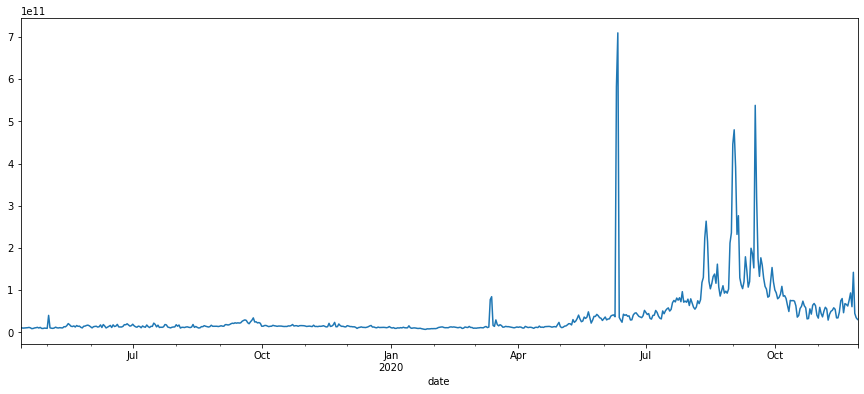

In [8]:
gas_plot = filter_series(df=gas, slice1=FIRST_SLICE_DATE, slice2=THIRD_SLICE_DATE)
gas_plot['gasValue'].plot(figsize = (15, 6))
plt.show()

## Splitting the series

We can see there is two-stage in the series. The first stage ends around May first of 2020, from then the series changed. So let's split the series into two slices. 

In [9]:
gas_slice1 = filter_series(df=gas, slice1=FIRST_SLICE_DATE, slice2=SECOND_SLICE_DATE)
gas_slice2 = filter_series(df=gas, slice1=SECOND_SLICE_DATE, slice2=THIRD_SLICE_DATE)

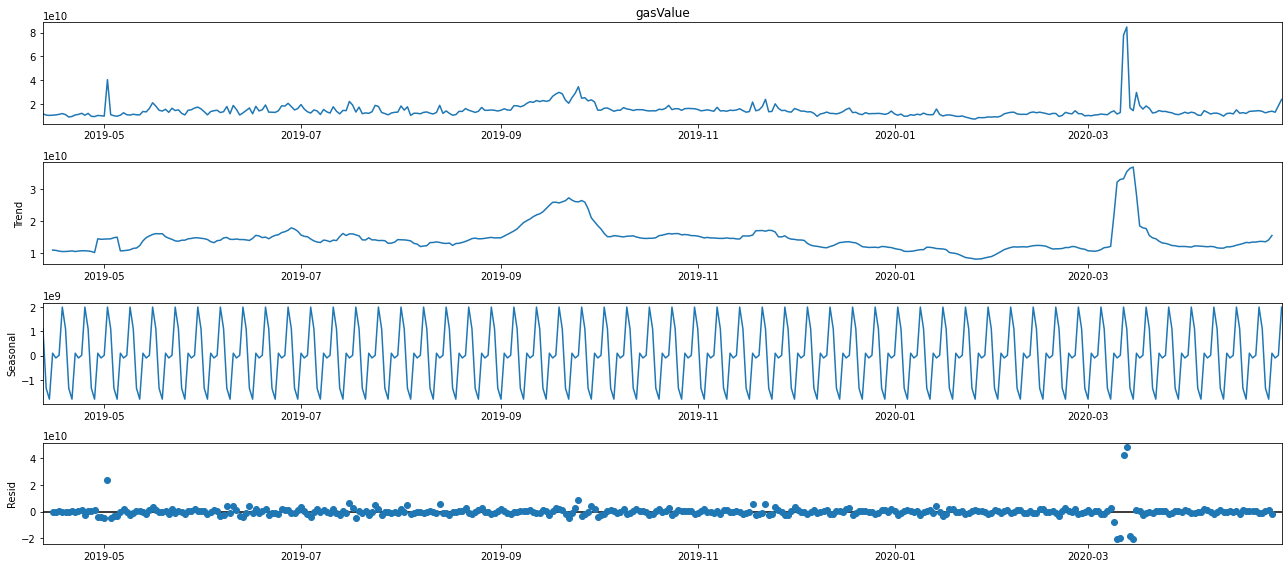

In [10]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(x=gas_slice1['gasValue'], model='additive')
fig = decomposition.plot()
plt.show()

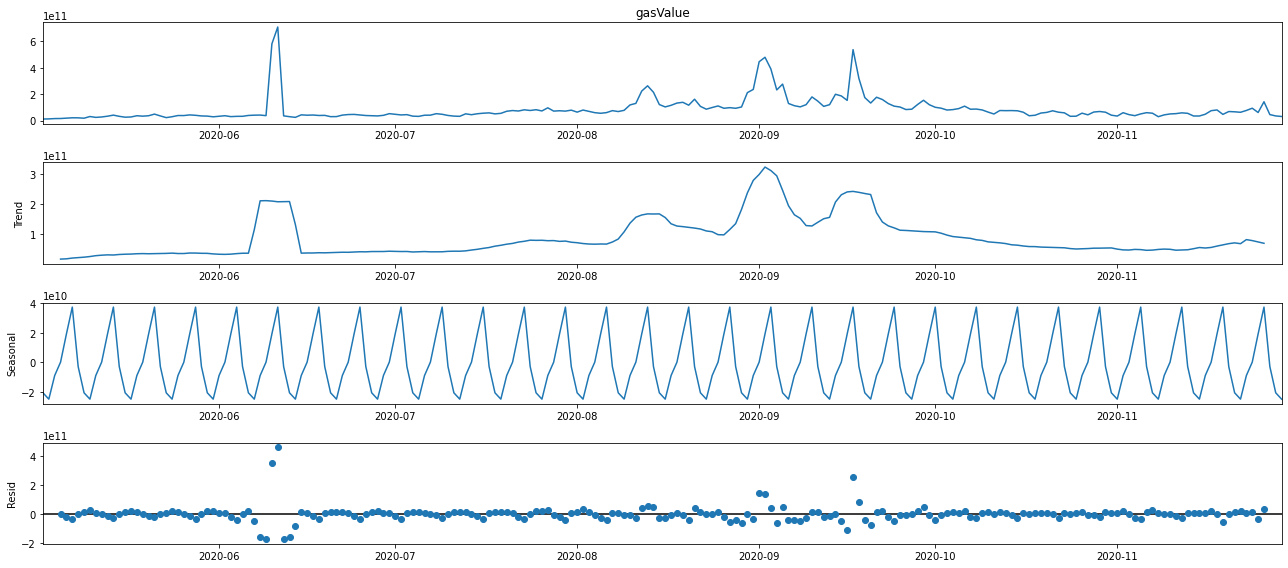

In [11]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(x=gas_slice2['gasValue'], model='additive')
fig = decomposition.plot()
plt.show()

Let's apply a log transformation to reduce higher gasValue, and also remove the weekly seasonality.

In [12]:
N = 7
gas_slice1['gasValue'] = gas_slice1['gasValue'] - gas_slice1['gasValue'].shift(N)
gas_slice1.dropna(inplace=True)

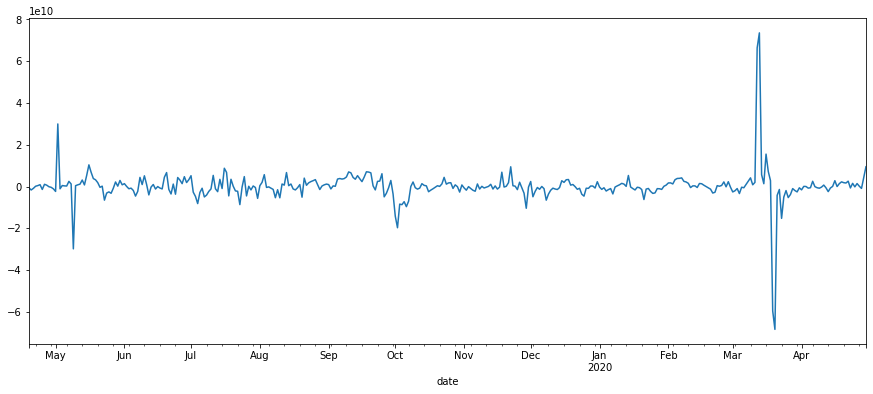

In [13]:
gas_slice1['gasValue'].plot(figsize = (15, 6))
plt.show()

In [14]:
gas_slice2['gasValue'] = gas_slice2['gasValue'] - gas_slice2['gasValue'].shift(N)
gas_slice2.dropna(inplace=True)

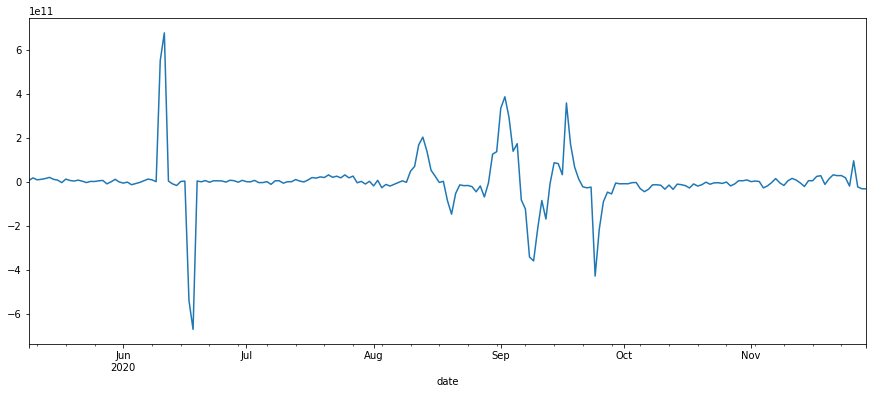

In [15]:
gas_slice2['gasValue'].plot(figsize = (15, 6))
plt.show()

## Augmented Dickey-Fuller

Let's test both series with augmented Dickey-Fuller test.

Where:

    * H0: The series has a unit root (non-stationary).
    * H1: The series has no unit root (stationary).

In [16]:
print_adf(df=gas_slice1, key='gasValue')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -5.258254
P-Value                   0.000007
# Lags Used              16.000000
# Observations Used     361.000000
Critical Value (1%)      -3.448595
Critical Value (5%)      -2.869580
Critical Value (10%)     -2.571053
dtype: float64


In [17]:
print_adf(df=gas_slice2, key='gasValue')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -4.359519
P-Value                   0.000350
# Lags Used              14.000000
# Observations Used     190.000000
Critical Value (1%)      -3.465244
Critical Value (5%)      -2.876875
Critical Value (10%)     -2.574945
dtype: float64


In both cases, we can reject the null hypothesis with all the confidence intervals. So, both series haven't a unit root. Hence, they are stationary series.

To confirm that, we are going to perform the kpss test for cross-validation.

## Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test

Where:

    * H0: The process is trend stationary.
    * H1: The series has a unit root (series is not stationary).

In [18]:
print_kpss(df=gas_slice1, key='gasValue')

KPSS Statistic: 0.021130158096859607
p-value: 0.1
num lags: 7
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [19]:
print_kpss(df=gas_slice2, key='gasValue')

KPSS Statistic: 0.04372962613084909
p-value: 0.1
num lags: 6
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In both cases, p-gasValue are greater than 0.05, and "KPSS Statistic" gasValue are less than the critical gasValue. So, we fail to reject H0, and because of that, we confirm that both series are stationary.

# DAOstack activity series

Let's check what about the activity series.

In [20]:
daostack: pd.DataFrame = pd.read_csv(os.path.join('data', 'daostack_activity.csv'), header=0)
daostack = transform_date_series(df=daostack, date_key='date')

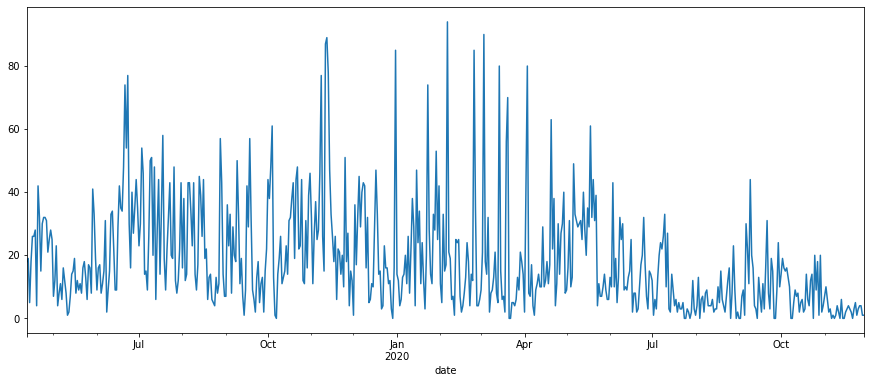

In [21]:
daostack_plot = filter_series(df=daostack, slice1=FIRST_SLICE_DATE, slice2=THIRD_SLICE_DATE)
daostack_plot['actions'].plot(figsize = (15, 6))
plt.show()

## Spliting the series

As we previously do with the gas series, let's split the series.

In [22]:
daostack_slice1 = filter_series(df=daostack, slice1=FIRST_SLICE_DATE, slice2=SECOND_SLICE_DATE)
daostack_slice2 = filter_series(df=daostack, slice1=SECOND_SLICE_DATE, slice2=THIRD_SLICE_DATE)

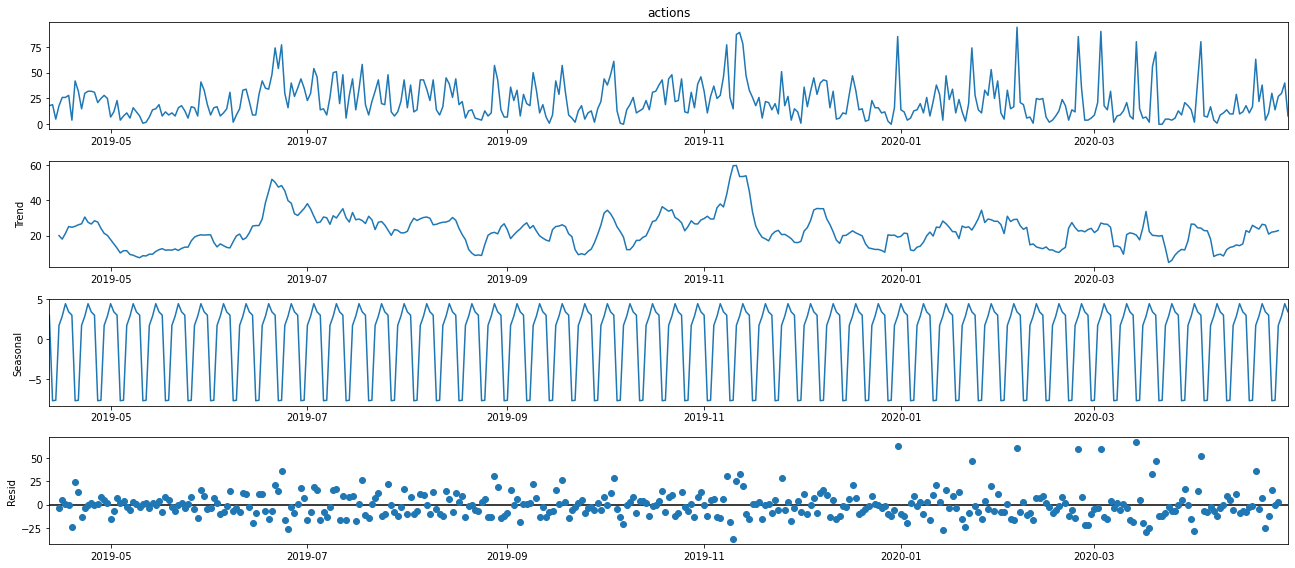

In [23]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(x=daostack_slice1['actions'], model='additive')
fig = decomposition.plot()
plt.show()

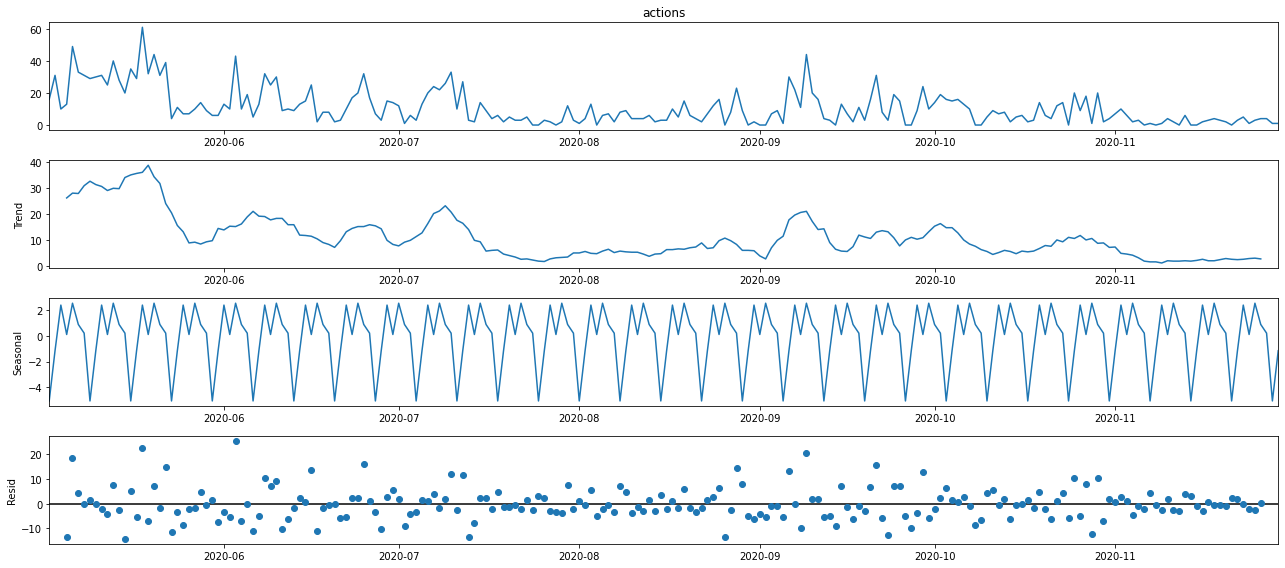

In [24]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(x=daostack_slice2['actions'], model='additive')
fig = decomposition.plot()
plt.show()

In [25]:
daostack_slice1['actions'] = daostack_slice1['actions'] - daostack_slice1['actions'].shift(N)
daostack_slice1.dropna(inplace=True)

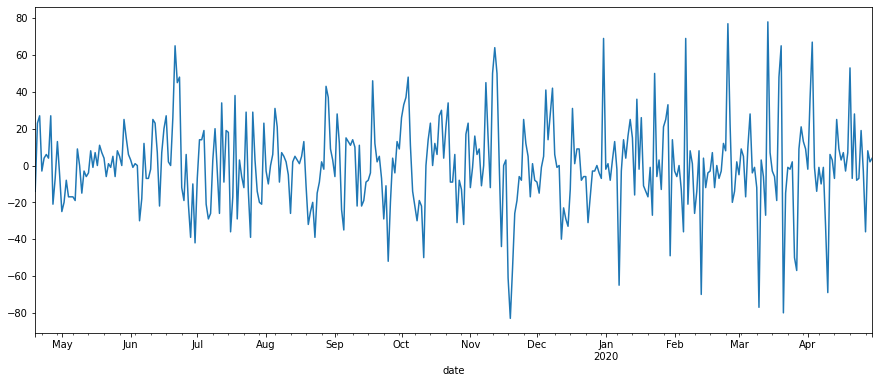

In [26]:
daostack_slice1['actions'].plot(figsize = (15, 6))
plt.show()

In [27]:
daostack_slice2['actions'] = daostack_slice2['actions'] - daostack_slice2['actions'].shift(N)
daostack_slice2.dropna(inplace=True)

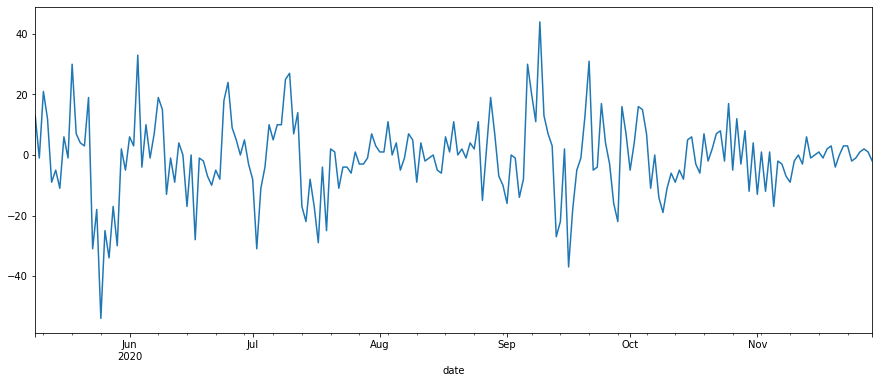

In [28]:
daostack_slice2['actions'].plot(figsize = (15, 6))
plt.show()

## Augmented Dickey-Fuller

Let's test both series with augmented Dickey-Fuller test.

Where:

    * H0: The series has a unit root (non-stationary).
    * H1: The series has no unit root (stationary).

In [29]:
print_adf(df=daostack_slice1, key='actions')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -7.516955e+00
P-Value                 3.880524e-11
# Lags Used             1.300000e+01
# Observations Used     3.640000e+02
Critical Value (1%)    -3.448443e+00
Critical Value (5%)    -2.869513e+00
Critical Value (10%)   -2.571018e+00
dtype: float64


In [30]:
print_adf(df=daostack_slice2, key='actions')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -7.295206e+00
P-Value                 1.383741e-10
# Lags Used             1.300000e+01
# Observations Used     1.910000e+02
Critical Value (1%)    -3.465059e+00
Critical Value (5%)    -2.876794e+00
Critical Value (10%)   -2.574901e+00
dtype: float64


In the first series, either p-value or statistic value are lower than all the confidence and critical gasValue. In the second case, its p-value is slower than the 0.05 confidence interval. Those results suggest that we can reject H0 in favor of H1, in other words, both series are stationary.

## Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test

Where:

    * H0: The process is trend stationary.
    * H1: The series has a unit root (series is not stationary).

In [31]:
print_kpss(df=daostack_slice1, key='actions')

KPSS Statistic: 0.01315012322107112
p-value: 0.1
num lags: 6
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [32]:
print_kpss(df=daostack_slice2, key='actions')

KPSS Statistic: 0.03797365857968079
p-value: 0.1
num lags: 7
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Both series have gasValue that suggest that we fail to reject H0. So, it is definitely a stationary series.

# Granger Causality Tests

Where:

    * H0: The second column, x2, does NOT Granger cause the time series in the first column, x1
    * H1: x2 Granger cause x1

In [33]:
slice1: pd.DataFrame = pd.DataFrame(
    {'daostack_actions': daostack_slice1['actions'].tolist(),
     'gasPrice': gas_slice1['gasValue'].tolist(),
    })
    
gc_res1 = grangercausalitytests(slice1, 8)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.6838  , p=0.0176  , df_denom=374, df_num=1
ssr based chi2 test:   chi2=5.7293  , p=0.0167  , df=1
likelihood ratio test: chi2=5.6862  , p=0.0171  , df=1
parameter F test:         F=5.6838  , p=0.0176  , df_denom=374, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.4093  , p=0.0128  , df_denom=371, df_num=2
ssr based chi2 test:   chi2=8.9375  , p=0.0115  , df=2
likelihood ratio test: chi2=8.8329  , p=0.0121  , df=2
parameter F test:         F=4.4093  , p=0.0128  , df_denom=371, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.2824  , p=0.0210  , df_denom=368, df_num=3
ssr based chi2 test:   chi2=10.0345 , p=0.0183  , df=3
likelihood ratio test: chi2=9.9026  , p=0.0194  , df=3
parameter F test:         F=3.2824  , p=0.0210  , df_denom=368, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.3340  , p=0.0553  

With a lag of 6 (chi2 -> p=0.0004) we can reject H0, and acept that gasValue granger cause the daostack activity.

In [37]:
slice2: pd.DataFrame = pd.DataFrame(
    {'daostack_actions': daostack_slice2['actions'].tolist(),
     'gasPrice': gas_slice2['gasValue'].tolist(),
    })
    
gc_res2 = grangercausalitytests(slice2, 20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4124  , p=0.5215  , df_denom=201, df_num=1
ssr based chi2 test:   chi2=0.4185  , p=0.5177  , df=1
likelihood ratio test: chi2=0.4181  , p=0.5179  , df=1
parameter F test:         F=0.4124  , p=0.5215  , df_denom=201, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7787  , p=0.4604  , df_denom=198, df_num=2
ssr based chi2 test:   chi2=1.5967  , p=0.4501  , df=2
likelihood ratio test: chi2=1.5904  , p=0.4515  , df=2
parameter F test:         F=0.7787  , p=0.4604  , df_denom=198, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6519  , p=0.1788  , df_denom=195, df_num=3
ssr based chi2 test:   chi2=5.1336  , p=0.1623  , df=3
likelihood ratio test: chi2=5.0694  , p=0.1668  , df=3
parameter F test:         F=1.6519  , p=0.1788  , df_denom=195, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5246  , p=0.1966  

# VAR analysis

## Slice 1

In [38]:
slice1: pd.DataFrame = gas_slice1.copy(deep=True)
slice1['actions'] = daostack_slice1['actions'].tolist()

In [39]:
model1 = VAR(slice1)
model1.select_order(15).summary()

/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


,AIC,BIC,FPE,HQIC
0,51.96,51.98,3.677e+22,51.97
1,51.56,51.63,2.475e+22,51.59
2,51.52,51.62,2.363e+22,51.56
3,51.46,51.61,2.240e+22,51.52
4,51.47,51.67,2.264e+22,51.55
5,51.47,51.71,2.253e+22,51.56
6,51.38,51.66,2.062e+22,51.49
7,50.97,51.29,1.370e+22,51.10
8,50.90,51.26*,1.274e+22,51.04*
9,50.91,51.32,1.288e+22,51.07


In [44]:
results1 = model1.fit(maxlags=15, ic='aic')
results1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 21, Dec, 2020
Time:                     12:48:01
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    51.4889
Nobs:                     363.000    HQIC:                   51.0881
Log likelihood:          -10192.7    FPE:                1.18258e+22
AIC:                      50.8237    Det(Omega_mle):     1.00381e+22
--------------------------------------------------------------------
Results for equation gasValue
                   coefficient        std. error           t-stat            prob
---------------------------------------------------------------------------------
const          43185592.549597  284217981.002009            0.152           0.879
L1.gasValue           0.735679          0.053472           13.758           0.000
L1.actions     30890746.357611   16037341.286974     

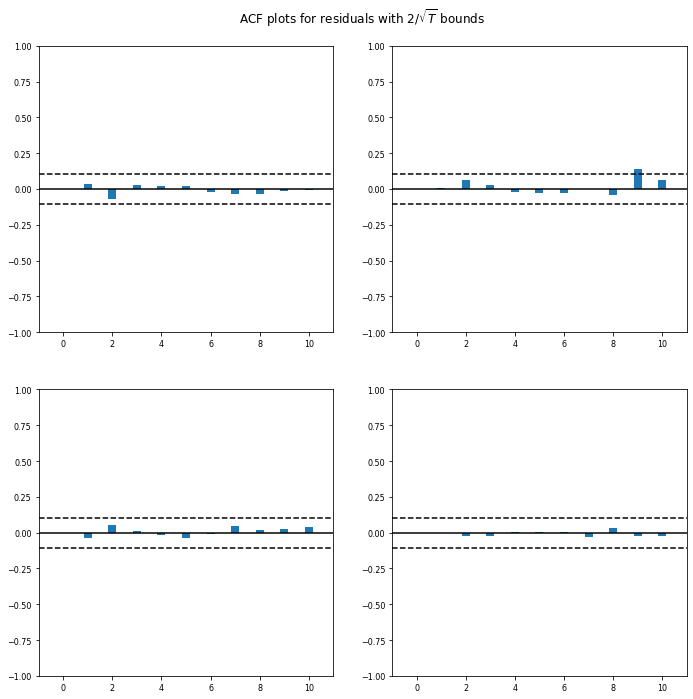

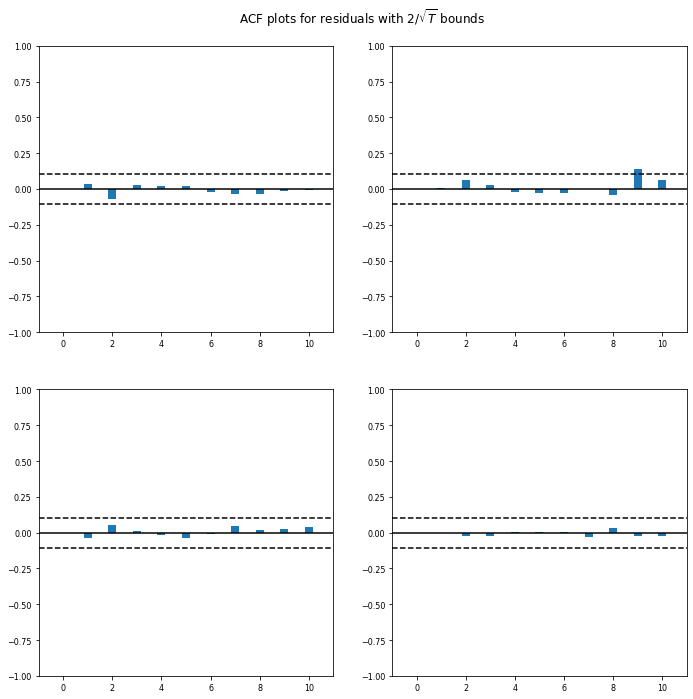

In [45]:
results1.plot_acorr()

### Impulse Response

In [46]:
irf1 = results1.irf(20)

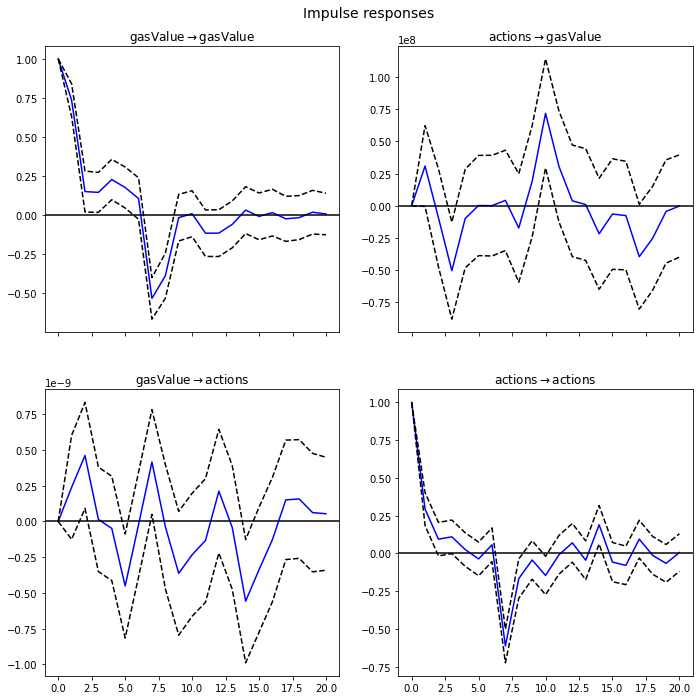

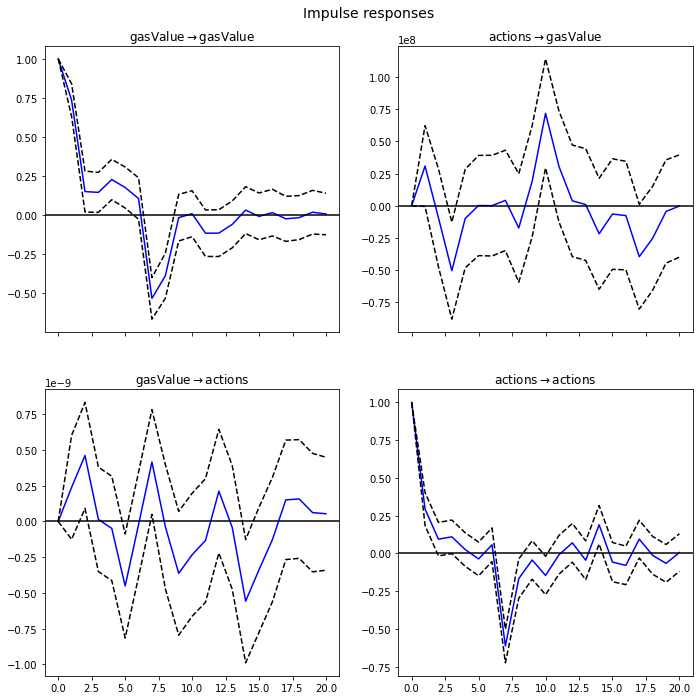

In [47]:
irf1.plot(orth=False)

In [48]:
irf1.cov(orth=False)

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00]],

       [[ 2.85930322e-03, -1.72269723e-12,  1.49102525e+05,
         -8.98325527e-05],
        [-1.72269723e-12,  3.44600348e-20, -8.98325527e-05,
          1.79696864e-12],
        [ 1.49102525e+05, -8.98325527e-05,  2.57196316e+14,
         -1.54957815e+05],
        [-8.98325527e-05,  1.79696864e-12, -1.54957815e+05,
          3.09970412e-03]],

       [[ 4.47116569e-03, -1.12841751e-12,  2.31202969e+05,
         -6.00163067e-05],
        [-1.12841751e-12,  3.58495954e-20, -5.84061775e-05,
          1.86485385e-12],
        [ 2.31202969e+05, -5.84061775e-05,  3.77326483e+14,
         -1.08615951e+05],
        [-6.00163067e-05,  1.86485385e-

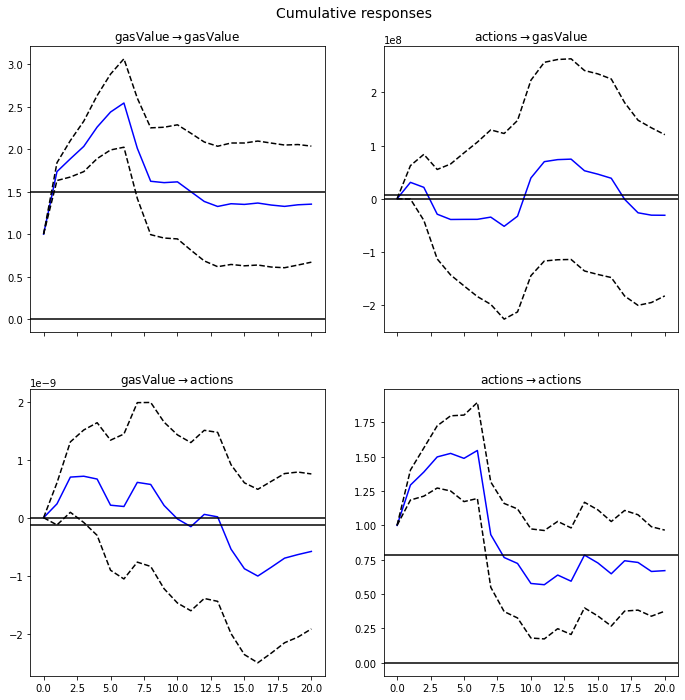

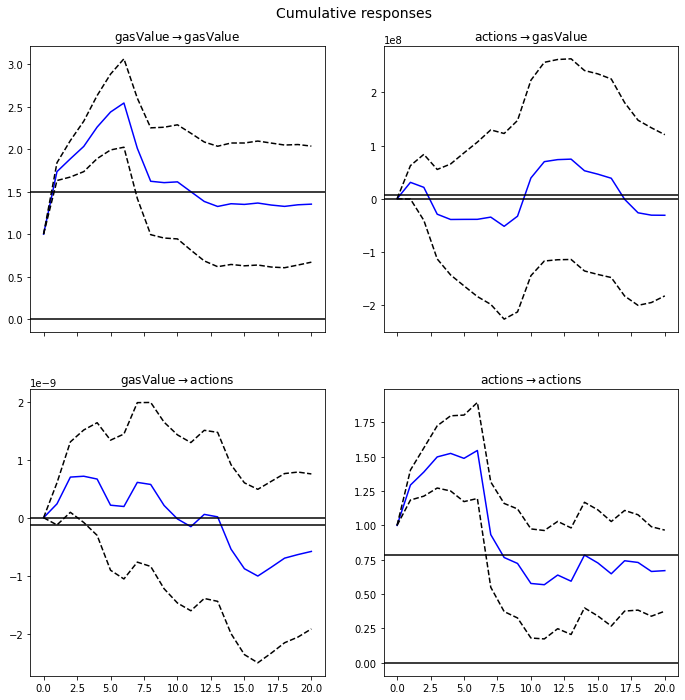

In [49]:
irf1.plot_cum_effects(orth=False)

In [50]:
irf1.cum_effect_cov(orth=False)

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00]],

       [[ 2.85930322e-03, -1.72269723e-12,  1.49102525e+05,
         -8.98325527e-05],
        [-1.72269723e-12,  3.44600348e-20, -8.98325527e-05,
          1.79696864e-12],
        [ 1.49102525e+05, -8.98325527e-05,  2.57196316e+14,
         -1.54957815e+05],
        [-8.98325527e-05,  1.79696864e-12, -1.54957815e+05,
          3.09970412e-03]],

       [[ 1.19702442e-02, -3.20214970e-12,  6.18639716e+05,
         -1.65976931e-04],
        [-3.20214970e-12,  9.62302397e-20, -1.64366802e-04,
          4.96993954e-12],
        [ 6.18639716e+05, -1.64366802e-04,  1.00019282e+15,
         -2.64012403e+05],
        [-1.65976931e-04,  4.96993954e-

## Slice 2

In [52]:
slice2: pd.DataFrame = gas_slice2.copy(deep=True)
slice2['actions'] = daostack_slice2['actions'].tolist()

In [53]:
model2 = sm.tsa.VAR(slice2)
model2.select_order(15).summary()

/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


,AIC,BIC,FPE,HQIC
0,56.16,56.19,2.450e+24,56.17
1,55.59,55.69,1.388e+24,55.63
2,55.53,55.70,1.306e+24,55.60
3,55.52,55.76,1.298e+24,55.62
4,55.53,55.84,1.314e+24,55.66
5,55.49,55.87,1.262e+24,55.65
6,55.42,55.87,1.176e+24,55.60
7,55.00,55.51,7.670e+23,55.20
8,54.91,55.49*,7.064e+23,55.15
9,54.87,55.52,6.768e+23,55.13


In [54]:
results2 = model2.fit(maxlags=15, ic='aic')
results2.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 21, Dec, 2020
Time:                     12:50:05
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    55.6408
Nobs:                     190.000    HQIC:                   55.0104
Log likelihood:          -5662.41    FPE:                5.09181e+23
AIC:                      54.5812    Det(Omega_mle):     3.76353e+23
--------------------------------------------------------------------
Results for equation gasValue
                     coefficient         std. error           t-stat            prob
------------------------------------------------------------------------------------
const          2741931808.854747  5834963854.816605            0.470           0.638
L1.gasValue             0.753551           0.077241            9.756           0.000
L1.actions      536632901.605428   722526

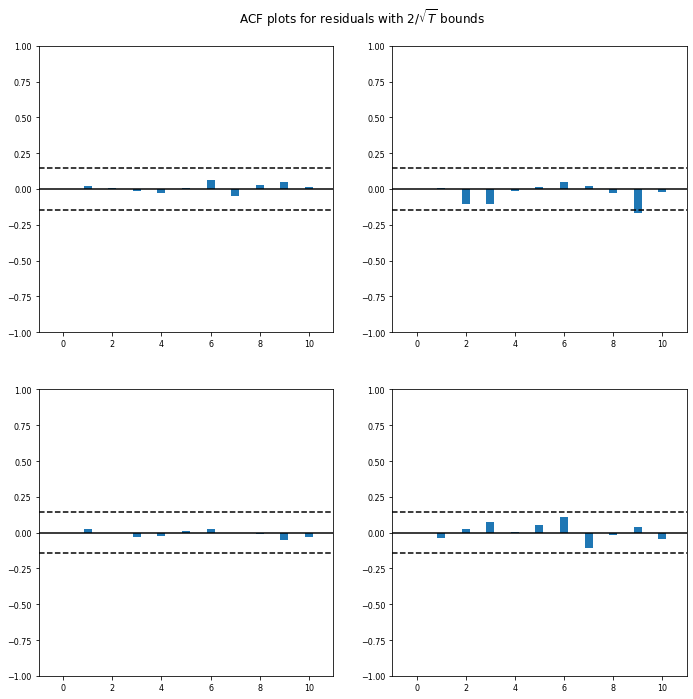

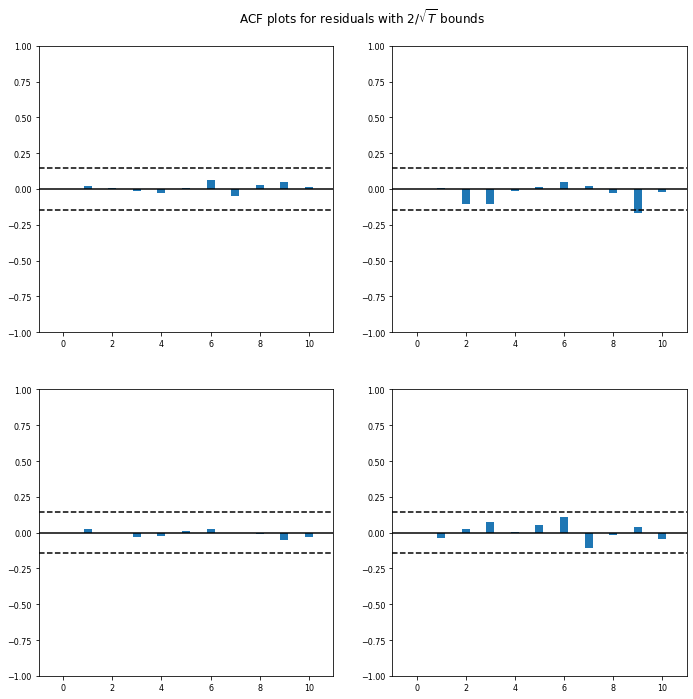

In [55]:
results2.plot_acorr()

### Impulse Response

In [56]:
irf2 = results2.irf(20)

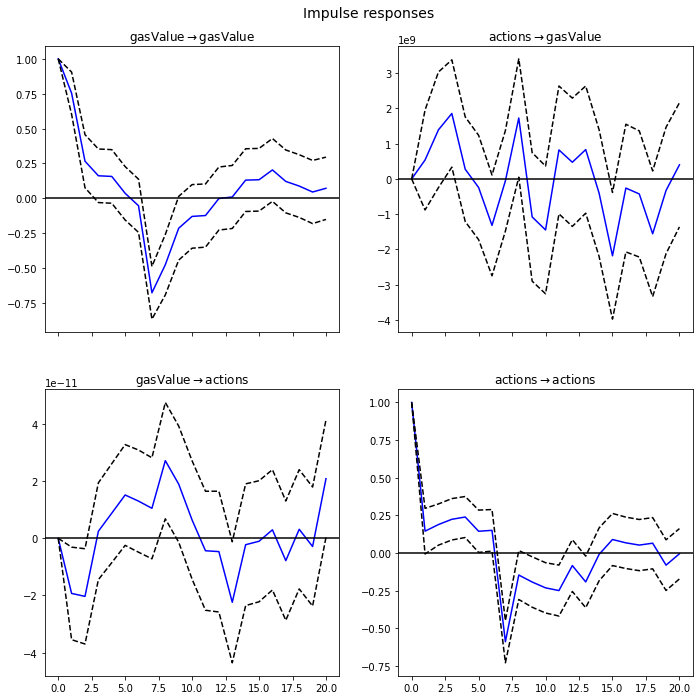

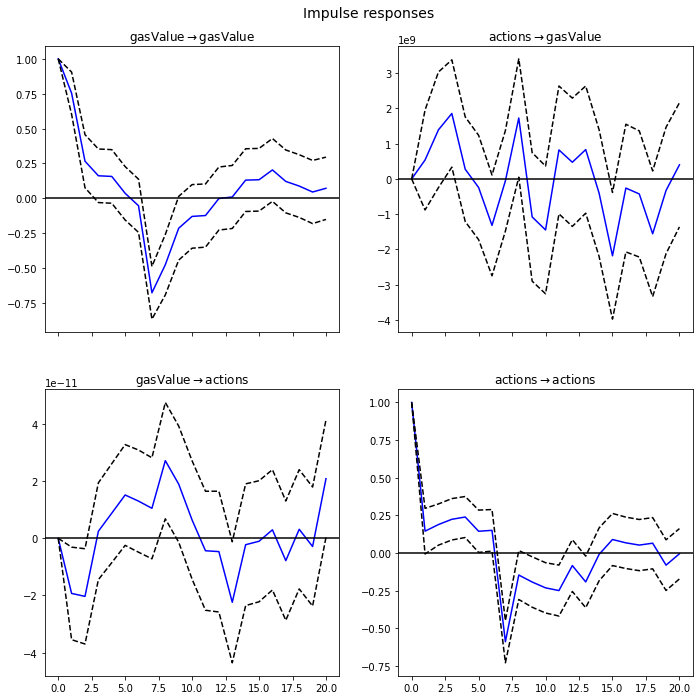

In [57]:
irf2.plot(orth=False)

In [58]:
irf2.cov(orth=False)

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00]],

       [[ 5.96611528e-03, -5.26576026e-14,  5.17617034e+06,
         -4.56854600e-05],
        [-5.26576026e-14,  6.82638156e-23, -4.56854600e-05,
          5.92253286e-14],
        [ 5.17617034e+06, -4.56854600e-05,  5.22044427e+17,
         -4.60762266e+06],
        [-4.56854600e-05,  5.92253286e-14, -4.60762266e+06,
          5.97319073e-03]],

       [[ 9.42874837e-03, -1.40756014e-13,  8.72421596e+06,
         -1.25462019e-04],
        [-1.40756014e-13,  7.23064913e-23, -1.40942490e-04,
          5.82052920e-14],
        [ 8.72421596e+06, -1.40942490e-04,  6.99367407e+17,
         -1.12165359e+07],
        [-1.25462019e-04,  5.82052920e-

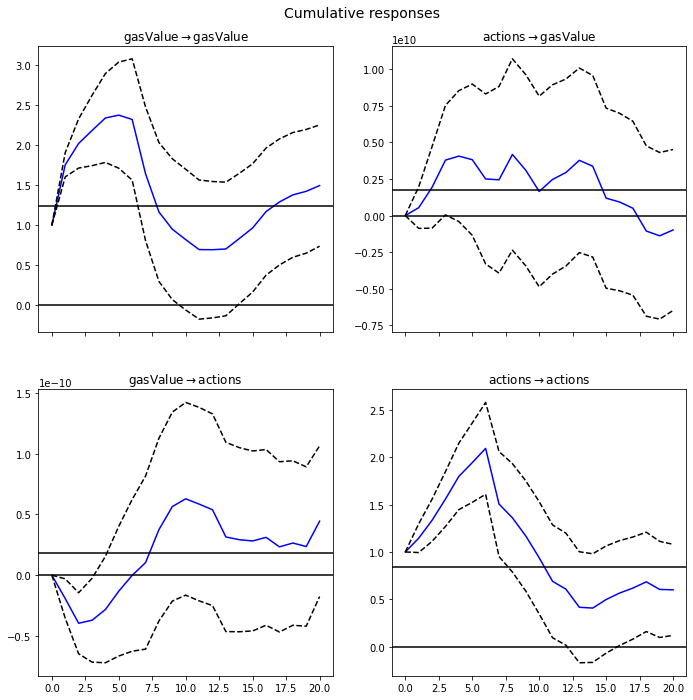

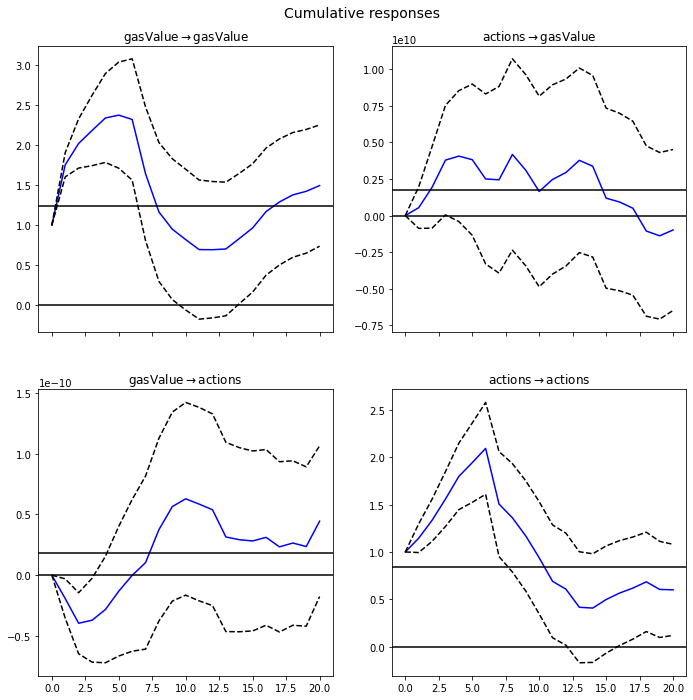

In [59]:
irf2.plot_cum_effects(orth=False)

In [60]:
irf2.cum_effect_cov(orth=False)

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00]],

       [[ 5.96611528e-03, -5.26576026e-14,  5.17617034e+06,
         -4.56854600e-05],
        [-5.26576026e-14,  6.82638156e-23, -4.56854600e-05,
          5.92253286e-14],
        [ 5.17617034e+06, -4.56854600e-05,  5.22044427e+17,
         -4.60762266e+06],
        [-4.56854600e-05,  5.92253286e-14, -4.60762266e+06,
          5.97319073e-03]],

       [[ 2.44841134e-02, -3.20582202e-13,  2.33830461e+07,
         -2.95572469e-04],
        [-3.20582202e-13,  1.64238371e-22, -3.11052940e-04,
          1.56236218e-13],
        [ 2.33830461e+07, -3.11052940e-04,  2.01909375e+18,
         -2.69724237e+07],
        [-2.95572469e-04,  1.56236218e-